In [10]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

print("#1 필요한 라이브러리 준비 완료..!")

#1 필요한 라이브러리 준비 완료..!


In [11]:
print("#2 데이터 가져오기..!")
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

# 데이터 모양 확인
print("train.shape: ", train.shape)
print("test.shape: ", test.shape)

# train 데이터 확인
train.head()

#2 데이터 가져오기..!
train.shape:  (15035, 21)
test.shape:  (6468, 20)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [12]:
print("#4 EDA 사전 작업..!")
y = train['price']
train_len = len(train)
train = pd.concat((train, test), axis=0)

print("train 크기: ",len(train)) # train + test
print(train.head())

#4 EDA 사전 작업..!
train 크기:  21503
   id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr

#5 결측치 처리
id : 0
date : 0
price : 6468
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


<AxesSubplot:>

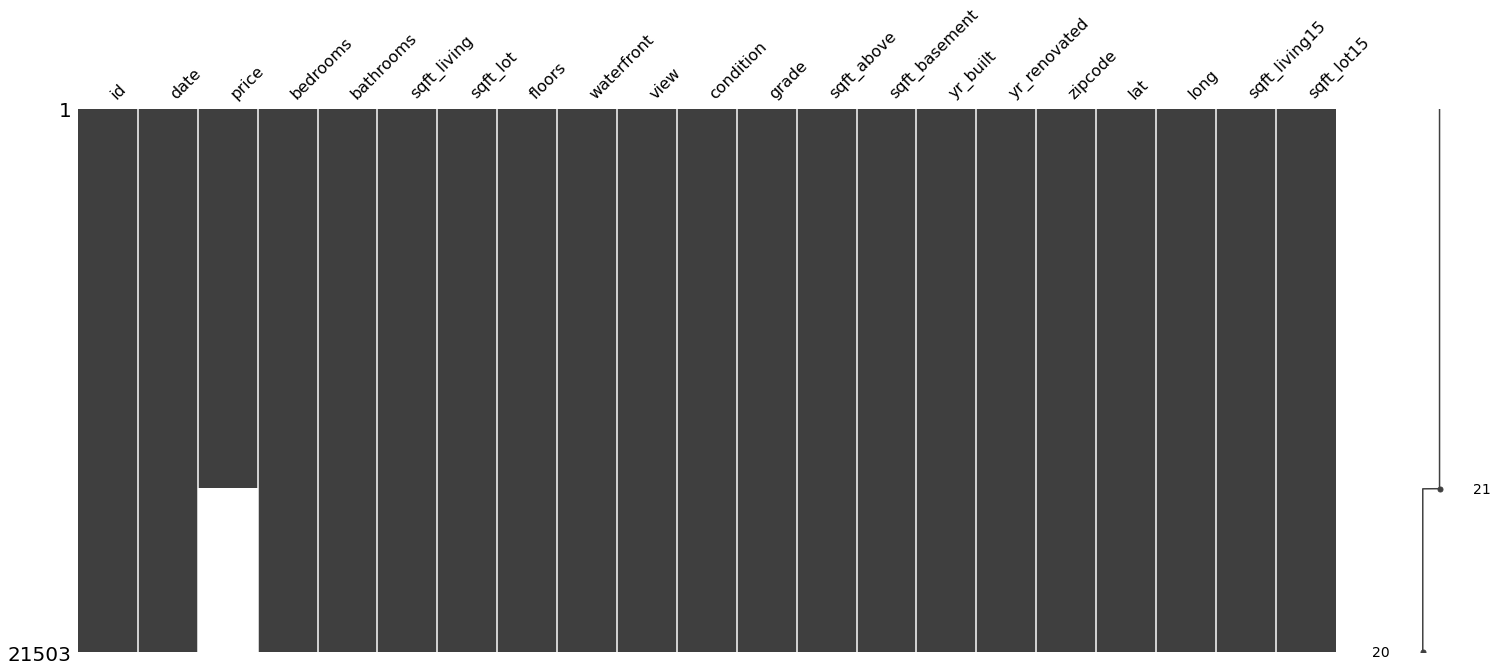

In [13]:
print("#5 결측치 처리")

# train 데이터의 결측치 for문으로 검거
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))
    
msno.matrix(train) # 결측치 시각화

In [14]:
print("#6 id값 제거")

try:
    test_id = train['id'][train_len:]
    del train['id']
    del test['id']
except:
    print('id가 존재하지 않습니다!!\n\n')

print(train.columns)

#6 id값 제거
Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [15]:
print("#7 date값 년,월,일로 format 변경")

for df in [train, test]:
    df['year'] = df['date'].apply(lambda x : str(x[0:4]), range(len(df))).astype(int)
    df['month'] = df['date'].apply(lambda x : str(x[4:6]), range(len(df))).astype(int)
    df['day'] = df['date'].apply(lambda x : str(x[6:8]), range(len(df))).astype(int)

train['year']
test['year']

#7 date값 년,월,일로 format 변경


0       2014
1       2014
2       2014
3       2015
4       2015
        ... 
6463    2014
6464    2015
6465    2015
6466    2014
6467    2015
Name: year, Length: 6468, dtype: int64

In [16]:
print("#8 데이터 분포, 상관관계 확인")

def correlation_plot():
    count = 0
    columns = train.columns
    fig, ax = plt.subplots(10, 2, figsize=(12, 30))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요.
    
    train['price'] = np.log1p(train['price'])
    
    for row in range(10):
        for col in range(2):
            try:
                # sns.regplot(np.log1p(train[columns[count]]), train['price'], ax=ax[row][col])
                sns.regplot(train[columns[count]], train['price'], ax=ax[row][col])
                ax[row][col].set_title(columns[count], fontsize=15)
                plt.tight_layout()
            except:
                print(columns[count])
            count += 1
            if count == 20:
                break
                
# correlation_plot()

#8 데이터 분포, 상관관계 확인


In [17]:
print("#9 데이터 준비")

del train['price']

# sqft_lot, lat, long - 제거
for df in [train, test]:
    try:
        df.drop(columns = ['date'], inplace = True) # , 'lat', 'long'
    except:
        print("이미 제거된 컬럼입니다.")
        

        
# 데이터 더미화
dummy_column = ['year', 'month', 'day'] # 'yr_built', 'yr_renovated', 'waterfront',  'zipcode'
for df in [train, test]:
    for dummy in dummy_column:
        df_dummy = pd.get_dummies(df[dummy], prefix=dummy)
        # 더미 변수 데이터프레임을 기존 데이터프레임에 병합
        df = df.drop(dummy, axis=1)
        df = pd.concat([df, df_dummy], axis=1)


#9 데이터 준비


In [18]:
print("#10 모델 학습 준비")
def rmse(y_test, y_pred):
    print(np.expm1(y_test))
    print(np.expm1(y_pred))
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

random_state=2020 #고정값 셋팅
from sklearn.linear_model import ElasticNet
from catboost import CatBoostRegressor

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)
catboost = CatBoostRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest, catboost]

y = np.log1p(y)
train2 = train.iloc[:train_len, :]

def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train2, y)

#10 모델 학습 준비


ModuleNotFoundError: No module named 'catboost'

In [ ]:
print("#11 그리드 탐색")
param_grid = {
    'n_estimators': [150,200,300],  # 더 다양한 값을 추가
    'max_depth': [10,20]  # 더 다양한 값을 추가
}

model = LGBMRegressor(random_state=random_state)

grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train2, y)

In [ ]:
params = grid_model.cv_results_['params']
params

In [ ]:
score = grid_model.cv_results_['mean_test_score']
score

In [ ]:
results = pd.DataFrame(params)
results['score'] = score

results

In [ ]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

In [ ]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

In [ ]:
results = results.sort_values('RMSLE')
results

In [ ]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train2, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [ ]:
param_grid = {
    'n_estimators': [150,200,300],  # 더 다양한 값을 추가
    'max_depth': [10,20]  # 더 다양한 값을 추가
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train2, y, param_grid, verbose=2, n_jobs=5)

In [ ]:
model = LGBMRegressor(max_depth=20, n_estimators=300, random_state=random_state)
# model = CatBoostRegressor(max_depth=15, n_estimators=200,random_state=random_state)
model.fit(train2, y)

In [ ]:
# train2.columns

In [ ]:
# test.columns

In [ ]:
prediction = model.predict(test)
prediction

In [ ]:
prediction = np.expm1(prediction)
prediction

In [ ]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

In [ ]:
submission['price'] = prediction
submission.head()

In [ ]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.161881')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

In [ ]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [ ]:
save_submission(model, train2, y, test, 'lgbm', rmsle='0.161881')